In [ ]:
!pip install brewer2mpl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Add, Activation, ZeroPadding2D,BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from PIL import Image    
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
import collections
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import datasets, layers, models
import random
import sys
import warnings 
warnings.filterwarnings('ignore')
#import brewer2mpl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#MODEL1
data = pd.read_csv('icml_face_data.csv')

In [ ]:
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
def prepare_data(data):
    """
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [ ]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
test_labels = to_categorical(test_image_label)

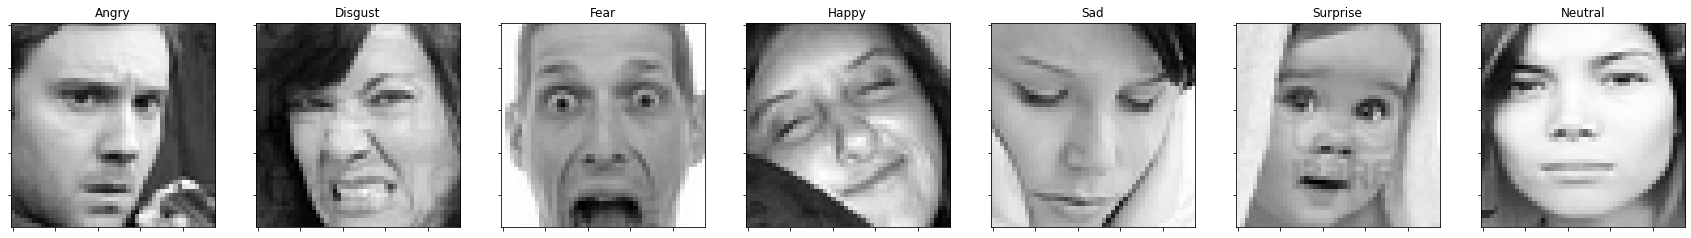

In [ ]:
plot_all_emotions()

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [ ]:
history = model.fit(train_images, train_labels,
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 82s 182ms/step - loss: 0.2469 - accuracy: 0.3844
Epoch 2/12
449/449 [==============================] - 82s 182ms/step - loss: 0.2360 - accuracy: 0.4113
Epoch 3/12
449/449 [==============================] - 82s 182ms/step - loss: 0.2233 - accuracy: 0.4428
Epoch 4/12
449/449 [==============================] - 81s 181ms/step - loss: 0.2113 - accuracy: 0.4741
Epoch 5/12
449/449 [==============================] - 82s 182ms/step - loss: 0.2028 - accuracy: 0.4973
Epoch 6/12
449/449 [==============================] - 82s 182ms/step - loss: 0.1960 - accuracy: 0.5154
Epoch 7/12
449/449 [==============================] - 82s 182ms/step - loss: 0.1895 - accuracy: 0.5335
Epoch 8/12
449/449 [==============================] - 81s 181ms/step - loss: 0.1830 - accuracy: 0.5489
Epoch 9/12
449/449 [==============================] - 81s 181ms/step - loss: 0.1774 - accuracy: 0.5655
Epoch 10/12
449/449 [==============================] - 81s 181ms/step - l

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 28ms/step - loss: 1.3485 - accuracy: 0.5277
test caccuracy: 0.5277236104011536


In [ ]:
#MODEL2 - ResNet50
data_set = pd.read_csv('/content/drive/MyDrive/train.csv')
examples = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
ax = np.array(data_set.emotion)
collections.Counter(ax)

NameError: ignored

In [ ]:
oversample = RandomOverSampler(sampling_strategy='auto')
# fit and apply the transform
X_over, y_over = oversample.fit_resample((data_set.pixels).values.reshape(-1, 1), data_set.emotion)


a = np.array(y_over)
collections.Counter(a)

NameError: ignored

In [ ]:
y_over = pd.Series(y_over)
y_over= y_over.values.reshape(len(y_over),1)

X_train,X_test,Y_train,Y_test = train_test_split(X_over,y_over, test_size=0.2)
#print(X_train[11])
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

In [ ]:
def preprocessing(pixels):
    a = []
    
    for i in range(len(pixels)):
            image_string = (pixels)[i].split(' ') 
            image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48,1)
            a.append(image_data)

    return a

In [ ]:
%matplotlib inline
a= []

X_train = pd.Series(X_train.flatten())
X_train_resnet50 =X_train
a = preprocessing(X_train)



X_train = np.array(a)
#X_test =test
# Y_train = y_over

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

NameError: ignored

In [ ]:
# ResNet50
a = []
for i in range(len(X_train_resnet50)):
            image_string = (X_train_resnet50)[i].split(' ') 
            image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
            a.append(image_data)


NameError: ignored

In [ ]:
X_train_resnet50 = np.array(a)
rgb_X_train = np.repeat(X_train_resnet50[..., np.newaxis], 3, -1)
print(rgb_X_train.shape)  # (size, 48, 48, 3)

model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = model1.output
x= Flatten()(x)
x = Dense(7, activation='softmax')(x)
model50 = keras.Model(inputs=model1.input, outputs=x)


model50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model50.fit(rgb_X_train, Y_train, batch_size=64, epochs=6, steps_per_epoch=len(X_train)/128, validation_split = 0.25)
model50.save('ResNEt50')

(40404, 48, 48, 3)
Epoch 1/6
315/315 [==============================] - 2607s 8s/step - loss: 2.3512 - accuracy: 0.3412 - val_loss: 1.4390 - val_accuracy: 0.4409
Epoch 2/6
315/315 [==============================] - 2601s 8s/step - loss: 1.2701 - accuracy: 0.5333 - val_loss: 1.3803 - val_accuracy: 0.5004
Epoch 3/6
315/315 [==============================] - 2646s 8s/step - loss: 1.2073 - accuracy: 0.5598 - val_loss: 1.0802 - val_accuracy: 0.5727
Epoch 4/6
315/315 [==============================] - 2643s 8s/step - loss: 0.8688 - accuracy: 0.6775 - val_loss: 3.5438 - val_accuracy: 0.2350
Epoch 5/6
315/315 [==============================] - 2637s 8s/step - loss: 1.2170 - accuracy: 0.5703 - val_loss: 2.0001 - val_accuracy: 0.3510
Epoch 6/6
315/315 [==============================] - 2660s 8s/step - loss: 1.1925 - accuracy: 0.5683 - val_loss: 1.3183 - val_accuracy: 0.5468
INFO:tensorflow:Assets written to: ResNEt50/assets


X_test shape: (10101, 1)
(10101, 48, 48)
316/316 [==============================] - 63s 199ms/step - loss: 1.2910 - accuracy: 0.5613
Neutral


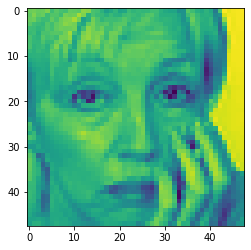

In [ ]:
Expressions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
a= []
print ("X_test shape: " + str(X_test.shape))
X_test50 = pd.Series(X_test.flatten())
a = []
for i in range(len(X_test50)):
            image_string = (X_test50)[i].split(' ') 
            image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
            a.append(image_data)


X_testing_array = np.array(a)
print(X_testing_array.shape)  # (size, 48, 48)
rgb_X_test = np.repeat(X_testing_array[..., np.newaxis], 3, -1)
# print(rgb_X_test.shape)  # (size, 48, 48, 3)

prediction = model50.predict(rgb_X_test)
model50.evaluate(rgb_X_test,Y_test)
    
results = Expressions[np.argmax(prediction[100])]
print(results)

image_string = X_test50[100].split(' ') 
image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
plt.imshow(image_data)

In [ ]:
#MODEL3 - InceptionResNetV2
train_csv = pd.read_csv('/content/drive/MyDrive/train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/test.csv')
split_df = pd.DataFrame([train_csv['pixels'][i].split() for i in range(train_csv.shape[0])])
train_joined = train_csv.join(split_df)
train_joined.drop('pixels',axis = 1,inplace = True)
Y_train = train_joined['emotion']
X_train = train_joined.iloc[:,1:2305]

x_train_raw = X_train.to_numpy()
y_train_raw = Y_train.to_numpy()

x_train = x_train_raw.astype(np.float64)
y_train = y_train_raw.astype(np.int)

x_train/=255
x_train,x_val, y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train_raw)
x_train = np.reshape(x_train,(x_train.shape[0],48,48,1))
x_val = np.reshape(x_val,(x_val.shape[0],48,48,1))
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       1

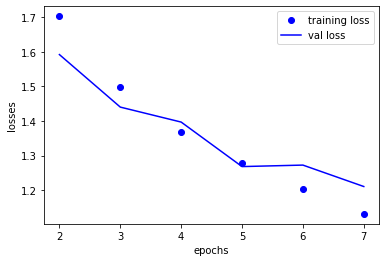

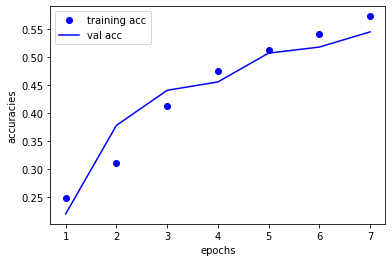

In [ ]:
model_3 = keras.Sequential()

model_3.add(Conv2D(256,(3,3),activation = 'relu', padding = 'same',input_shape = (48,48,1)))
model_3.add(MaxPooling2D(2,2))
model_3.add(Dropout(0.3))


model_3.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_3.add(MaxPooling2D(2,2))
model_3.add(Dropout(0.3))


model_3.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_3.add(MaxPooling2D(2,2))
model_3.add(Dropout(0.3))


model_3.add(Conv2D(256,(5,5),activation = 'relu', padding = 'same'))
model_3.add(MaxPooling2D(2,2))
model_3.add(Dropout(0.3))


model_3.add(Flatten())
model_3.add(Dense(256,activation='relu'))
model_3.add(Dense(256,activation='relu'))
model_3.add(Dense(7,activation='softmax'))
model_3.summary()

model_3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = model_3.fit(x_train,y_train,validation_data = (x_val,y_val),epochs = 7, batch_size = 128,verbose=1)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs[1:],loss[1:],'bo',label='training loss')
plt.plot(epochs[1:],val_loss[1:],'b',label='val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

plt.plot(epochs,acc,'bo',label='training acc')
plt.plot(epochs,val_acc,'b',label='val acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.show()


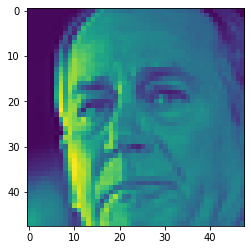

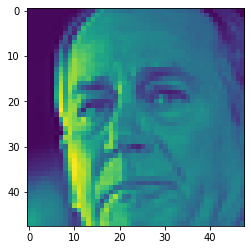

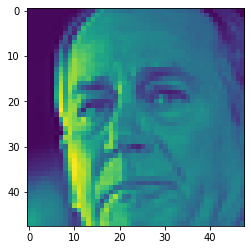

In [ ]:
#InceptionResNetV2m_pre = Sequential()
from tensorflow.keras.applications import InceptionResNetV2

# Since ResNetV2 expects 3 input channels we repeat the image

x_train_3c = x_train[:,:,:,:,np.newaxis]
x_train_3c.shape
x_train_rgb = np.repeat(x_train, 3, -1)

plt.imshow(x_train_rgb[0,:,:,0].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,1].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,2].reshape(48,48))
plt.show()

x_val_rgb = np.repeat(x_val,3,-1)

In [ ]:
print(x_val_rgb.shape)
print(x_train_rgb.shape)

(5742, 48, 48, 3)
(22967, 48, 48, 3)


In [ ]:
conv_base = InceptionResNetV2(include_top = False,weights ='imagenet')
conv_base.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model = keras.Sequential()
model.add(keras.layers.ZeroPadding2D((75,75), input_shape = (48,48,3)))

In [ ]:
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',metrics = ['accuracy'],loss='categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 198, 198, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3145856   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 57,483,495
Trainable params: 3,146,759
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
history = model.fit(x_train_rgb,y_train, validation_data = (x_val_rgb,y_val), epochs = 7, batch_size = 256)

Epoch 1/7
90/90 [==============================] - 4677s 52s/step - loss: 21.5951 - accuracy: 0.2052 - val_loss: 5.1444 - val_accuracy: 0.1536
Epoch 2/7
90/90 [==============================] - 4683s 52s/step - loss: 4.8435 - accuracy: 0.2483 - val_loss: 3.9805 - val_accuracy: 0.3614
Epoch 3/7
90/90 [==============================] - 4667s 52s/step - loss: 3.5311 - accuracy: 0.2701 - val_loss: 1.7973 - val_accuracy: 0.4006
Epoch 4/7
90/90 [==============================] - 4668s 52s/step - loss: 3.0744 - accuracy: 0.2958 - val_loss: 3.4208 - val_accuracy: 0.2335
Epoch 5/7
90/90 [==============================] - 4671s 52s/step - loss: 2.9180 - accuracy: 0.3000 - val_loss: 3.0120 - val_accuracy: 0.3447
Epoch 6/7
90/90 [==============================] - 4689s 52s/step - loss: 2.5847 - accuracy: 0.3253 - val_loss: 2.2157 - val_accuracy: 0.3497
Epoch 7/7
90/90 [==============================] - 4693s 52s/step - loss: 2.0756 - accuracy: 0.3285 - val_loss: 1.6492 - val_accuracy: 0.3748


In [ ]:
def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry',"Happy"], filepath='/content/drive/MyDrive/face_data.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df[' Usage'] == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data[" pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [ ]:
## All three datasets are well loaded accordingly
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,usage= 'PublicTest')

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 6)
(3589, 48, 48, 1)
(3589, 6)
(3589, 48, 48, 1)
(3589, 6)


In [ ]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (zip(labels, counts))

Private test set


In [ ]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

In [ ]:
# Final Model Architecture:
from keras import layers
from keras import models
from keras import optimizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')


#fit
nb_epoch = 7
batch_size = 128

modelF = modelN.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,validation_data=(X_val, y_val), shuffle=True, verbose=1)

Training....
Epoch 1/7
225/225 [==============================] - 559s 2s/step - loss: 1.7677 - accuracy: 0.2510 - val_loss: 1.7218 - val_accuracy: 0.2669
Epoch 2/7
225/225 [==============================] - 557s 2s/step - loss: 1.6341 - accuracy: 0.3208 - val_loss: 1.4185 - val_accuracy: 0.4411
Epoch 3/7
225/225 [==============================] - 557s 2s/step - loss: 1.4034 - accuracy: 0.4387 - val_loss: 1.3071 - val_accuracy: 0.4943
Epoch 4/7
225/225 [==============================] - 557s 2s/step - loss: 1.2603 - accuracy: 0.5056 - val_loss: 1.2141 - val_accuracy: 0.5261
Epoch 5/7
225/225 [==============================] - 557s 2s/step - loss: 1.1512 - accuracy: 0.5525 - val_loss: 1.1886 - val_accuracy: 0.5352
Epoch 6/7
225/225 [==============================] - 558s 2s/step - loss: 1.0715 - accuracy: 0.5860 - val_loss: 1.1528 - val_accuracy: 0.5667
Epoch 7/7
225/225 [==============================] - 559s 2s/step - loss: 0.9773 - accuracy: 0.6289 - val_loss: 1.1661 - val_accuracy: 

INFO:tensorflow:Assets written to: facial_1/assets


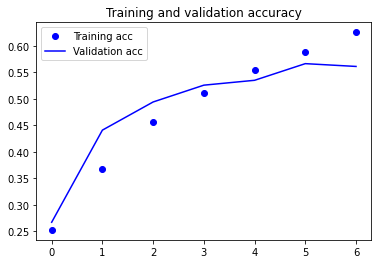

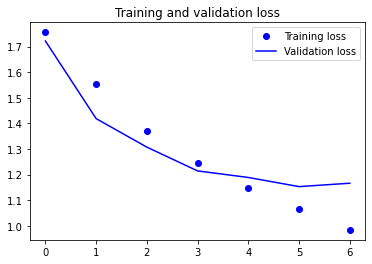

In [ ]:
modelN.save('facial_1')

acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/test.csv')
split_df = pd.DataFrame([train_csv['pixels'][i].split() for i in range(train_csv.shape[0])])
train_joined = train_csv.join(split_df)
train_joined.drop('pixels',axis = 1,inplace = True)
Y_train = train_joined['emotion']
X_train = train_joined.iloc[:,1:2305]

x_train_raw = X_train.to_numpy()
y_train_raw = Y_train.to_numpy()

x_train = x_train_raw.astype(np.float64)
y_train = y_train_raw.astype(np.int)

x_train/=255
x_train,x_val, y_train,y_val = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train_raw)
x_train = np.reshape(x_train,(x_train.shape[0],48,48,1))
x_val = np.reshape(x_val,(x_val.shape[0],48,48,1))
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
    

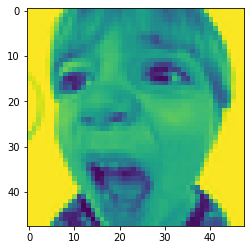

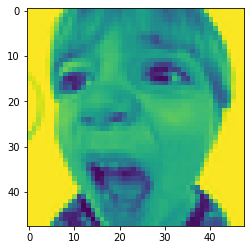

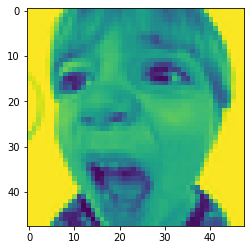

In [ ]:
x_train_3c = x_train[:,:,:,:,np.newaxis]
x_train_3c.shape
x_train_rgb = np.repeat(x_train, 3, -1)

plt.imshow(x_train_rgb[0,:,:,0].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,1].reshape(48,48))
plt.show()
plt.imshow(x_train_rgb[0,:,:,2].reshape(48,48))
plt.show()

x_val_rgb = np.repeat(x_val,3,-1)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.models import Model
from sklearn import preprocessing

In [ ]:
VGG16 = VGG16(weights="imagenet", include_top=False)
VGG16.trainable = False

In [ ]:
model = keras.Sequential()
model.add(keras.layers.ZeroPadding2D((75,75), input_shape = (48,48,3)))
model.add(VGG16)
model.add(Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',metrics = ['accuracy'],loss='categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 198, 198, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 17,075,015
Trainable params: 2,360,327
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(x_train_rgb,y_train, validation_data = (x_val_rgb,y_val), epochs = 40, batch_size = 256)

Epoch 1/40
90/90 [==============================] - 46s 514ms/step - loss: 2.4500 - accuracy: 0.2297 - val_loss: 1.8441 - val_accuracy: 0.2870
Epoch 2/40
90/90 [==============================] - 42s 464ms/step - loss: 1.8940 - accuracy: 0.2727 - val_loss: 1.6642 - val_accuracy: 0.3549
Epoch 3/40
90/90 [==============================] - 42s 464ms/step - loss: 1.7772 - accuracy: 0.3079 - val_loss: 1.8888 - val_accuracy: 0.3177
Epoch 4/40
90/90 [==============================] - 42s 465ms/step - loss: 1.7089 - accuracy: 0.3293 - val_loss: 1.6214 - val_accuracy: 0.3582
Epoch 5/40
90/90 [==============================] - 42s 464ms/step - loss: 1.6624 - accuracy: 0.3446 - val_loss: 1.6158 - val_accuracy: 0.3704
Epoch 6/40
90/90 [==============================] - 42s 465ms/step - loss: 1.6379 - accuracy: 0.3563 - val_loss: 1.6327 - val_accuracy: 0.3555
Epoch 7/40
90/90 [==============================] - 42s 464ms/step - loss: 1.6148 - accuracy: 0.3633 - val_loss: 1.7273 - val_accuracy: 0.3269

PARTIE2

In [ ]:
import tarfile
tf = tarfile.open("/content/drive/MyDrive/fer2013 (1).tar.gz")
tf.extractall()

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
df = pd.read_csv('/content/fer2013/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
24780,4,196 190 128 96 185 195 155 98 49 77 90 89 78 4...,Training
24781,3,119 120 130 161 180 186 189 188 197 203 206 21...,Training
24782,2,147 143 136 130 135 150 150 138 120 130 133 13...,Training
24783,3,207 209 202 197 183 203 178 109 125 127 127 12...,Training


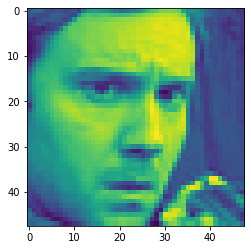

In [ ]:
img = df['pixels'][0]
img = img.split()
img = [float(i) for i in img]
img = np.array(img)
img = img.reshape((48,48))
train = df[df['Usage'] == 'Training']
test = df[df['Usage'] == 'PrivateTest']
plt.imshow(img)
import os
from skimage.color import gray2rgb
"""
os.mkdir("/content/train/")
os.mkdir("/content/test/")
for cat in df.emotion.unique():
  os.mkdir("/content/train/{}".format(cat))
  os.mkdir("/content/test/{}".format(cat))
"""
count = 0
X = []
Y = []
for img,em in zip(train['pixels'],train['emotion']):
  img = img.split()
  img = [float(i) for i in img]
  img = np.array(img)
  X.append(img.reshape(48*48,))
  count += 1
  img = gray2rgb(img.reshape((48,48)))
  Y.append(em)
  cv2.imwrite("/content/train/{}/{}".format(em,'img{}.png'.format(count)),img)

In [ ]:
xtest = []
ytest = []
for img,em in zip(test['pixels'],test['emotion']):
  img = img.split()
  img = [float(i) for i in img]
  img = np.array(img)
  img = img.reshape((48,48,1))
  
  xtest.append(img.reshape(48*48,))
  count += 1
  ytest.append(em)
  img = gray2rgb(img.reshape((48,48)))
  cv2.imwrite("/content/test/{}/{}".format(em,'img{}.png'.format(count)),img)

In [ ]:
#MobileNet
#imports
import keras 
from keras import models
from keras.applications import DenseNet201, MobileNet

from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import os
import numpy as np
from google.colab import drive,files
import cv2
from keras import layers
import matplotlib.pyplot as  plt
from keras import models
from keras.models import load_model,model_from_json
base_model = MobileNet(weights='imagenet',input_shape=(48,48,3),include_top=False)
model = models.Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# batch size
bs = 16

data_gen = ImageDataGenerator(rescale=1/255.,)
train_gen = data_gen.flow_from_directory('/content/train',target_size=(48,48),batch_size=bs)
test_gen = data_gen.flow_from_directory('/content/test',target_size=(48,48),batch_size=bs)
model.fit_generator(train_gen, train_gen.n//bs,
                    validation_data=test_gen, validation_steps=test_gen.n//bs ,
                    epochs=30)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                30750     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)               

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1794/1794 [==============================] - 39s 17ms/step - loss: 2.0855 - accuracy: 0.2307 - val_loss: 1.5767 - val_accuracy: 0.4026
Epoch 2/30
1794/1794 [==============================] - 30s 17ms/step - loss: 1.5982 - accuracy: 0.3780 - val_loss: 1.4860 - val_accuracy: 0.4199
Epoch 3/30
1794/1794 [==============================] - 30s 17ms/step - loss: 1.5164 - accuracy: 0.4166 - val_loss: 1.4264 - val_accuracy: 0.4654
Epoch 4/30
1794/1794 [==============================] - 30s 17ms/step - loss: 1.4513 - accuracy: 0.4448 - val_loss: 1.4392 - val_accuracy: 0.4528
Epoch 5/30
1794/1794 [==============================] - 30s 17ms/step - loss: 1.4322 - accuracy: 0.4591 - val_loss: 1.3793 - val_accuracy: 0.4791
Epoch 6/30
1794/1794 [==============================] - 30s 17ms/step - loss: 1.3663 - accuracy: 0.4890 - val_loss: 1.3303 - val_accuracy: 0.5100
Epoch 7/30
1794/1794 [==============================] - 31s 17ms/step - loss: 1.3249 - accuracy: 0.5042 - val_loss: 1.3392 -

In [ ]:
#EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
#imports
import keras 
from keras import models
from keras.applications import ResNet50, ResNet50V2, DenseNet201

from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import os
import numpy as np
from google.colab import drive,files
import cv2
from keras import layers
import matplotlib.pyplot as  plt
from keras import models
from keras.models import load_model,model_from_json
base_model = EfficientNetB0(weights='imagenet',input_shape=(48,48,3),include_top=False)
model = models.Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# batch size
bs = 16

data_gen = ImageDataGenerator(rescale=1/255.,)
train_gen = data_gen.flow_from_directory('/content/train',target_size=(48,48),batch_size=bs)
test_gen = data_gen.flow_from_directory('/content/test',target_size=(48,48),batch_size=bs)
model.fit_generator(train_gen, train_gen.n//bs,
                    validation_data=test_gen, validation_steps=test_gen.n//bs ,
                    epochs=30)

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 1280)        5120      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                38430     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1794/1794 [==============================] - 78s 36ms/step - loss: 1.8838 - accuracy: 0.2536 - val_loss: 1.9366 - val_accuracy: 0.1663
Epoch 2/30
1794/1794 [==============================] - 63s 35ms/step - loss: 1.5329 - accuracy: 0.4184 - val_loss: 1.8741 - val_accuracy: 0.1822
Epoch 3/30
1794/1794 [==============================] - 62s 35ms/step - loss: 1.4024 - accuracy: 0.4744 - val_loss: 1.9911 - val_accuracy: 0.1655
Epoch 4/30
1794/1794 [==============================] - 62s 35ms/step - loss: 1.3382 - accuracy: 0.5026 - val_loss: 2.1269 - val_accuracy: 0.1657
Epoch 5/30
1794/1794 [==============================] - 62s 35ms/step - loss: 1.2689 - accuracy: 0.5331 - val_loss: 1.9758 - val_accuracy: 0.1878
Epoch 6/30
1794/1794 [==============================] - 62s 34ms/step - loss: 1.2230 - accuracy: 0.5517 - val_loss: 2.1626 - val_accuracy: 0.1992
Epoch 7/30
1794/1794 [==============================] - 61s 34ms/step - loss: 1.1633 - accuracy: 0.5718 - val_loss: 3.4878 -

In [ ]:
X = np.array(X)
Y = np.array(Y)
X.shape

(28709, 2304)

In [ ]:
xtest = np.array(xtest)
ytest = np.array(ytest)
xtest.shape

(3589, 2304)

In [ ]:
#LSTM Simple
from keras.layers import Dense, Conv1D, Input, MaxPooling1D, Flatten, Dropout, LSTM
from keras import Sequential
from keras.utils import to_categorical
cat_Y = to_categorical(Y)

X_ = np.reshape(X,(28709, 2304,1))

cat_ytest=to_categorical(ytest)
xtest_=np.reshape(xtest,(3589, 2304,1))

model = Sequential()
model.add(LSTM(100,return_sequences=True,  input_shape=(2304, 1)))
model.add(LSTM(32,return_sequences = True))
model.add(LSTM(10))
model.add(Dense(7, activation='softmax', ))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_, cat_Y, batch_size=10, epochs=30, validation_data=(xtest_, cat_ytest))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2304, 100)         40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 2304, 32)          17024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense (Dense)                (None, 7)                 77        
Total params: 59,621
Trainable params: 59,621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
2871/2871 [==============================] - 590s 202ms/step - loss: 1.8139 - accuracy: 0.2460 - val_loss: 1.8095 - val_accuracy: 0.2527
Epoch 2/30
2871/2871 [==============================] - 579s 202ms/step - loss: 1.7942 - accuracy

In [ ]:
#CNN+LSTM (CONV1D)
model = Sequential()
model.add(Conv1D(32, 4, activation='relu', padding='same', input_shape=(2304, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(128))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_, cat_Y, batch_size=10, epochs=30, validation_data=(xtest_, cat_ytest))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2304, 32)          160       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2304, 32)          8320      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1152, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1152, 16)          4112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1152, 64)          20736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 576, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 576, 16)          

In [ ]:
#CNN+LSTM (CONV2D)
from keras.layers import Convolution2D,Dropout,Activation, MaxPooling2D, TimeDistributed, Reshape,Conv2D,Flatten,InputLayer
from keras import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
cat_Y = to_categorical(Y)
cnn = Sequential()
model = Sequential()
Xr = np.reshape(X,(28709,48,48,1))

cat_Testy=to_categorical(ytest)
testX=np.reshape(xtest,(3589,48,48,1))

model.add(InputLayer(input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(10))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(Xr,cat_Y,batch_size=10, epochs=30, validation_data=(testX, cat_Testy))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 23, 1472)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                59320     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 77        
Total params: 60,037
Trainable params: 60,037
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
2871/2871 [==============================] - 13s 4ms/step - loss: 1.8545 - accuracy: 0.2132 - val_l

In [ ]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
#VGG16
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable) 

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 2s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98

In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/train.zip' -d train

In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/test-public.zip' -d dev

In [ ]:
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
)

Epoch 1/100
224/224 [==============================] - 304s 1s/step - loss: 1.4368 - accuracy: 0.4525 - val_loss: 1.1419 - val_accuracy: 0.5764
Epoch 2/100


/tensorflow-1.15.2/python3.6/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


224/224 [==============================] - 294s 1s/step - loss: 1.1974 - accuracy: 0.5546 - val_loss: 1.2185 - val_accuracy: 0.5893
Epoch 3/100
224/224 [==============================] - 293s 1s/step - loss: 1.1397 - accuracy: 0.5730 - val_loss: 1.0767 - val_accuracy: 0.6040
Epoch 4/100
224/224 [==============================] - 289s 1s/step - loss: 1.1184 - accuracy: 0.5791 - val_loss: 0.9801 - val_accuracy: 0.6076
Epoch 5/100
224/224 [==============================] - 286s 1s/step - loss: 1.0941 - accuracy: 0.5919 - val_loss: 1.1220 - val_accuracy: 0.6034
Epoch 6/100
224/224 [==============================] - 288s 1s/step - loss: 1.0811 - accuracy: 0.5941 - val_loss: 0.9557 - val_accuracy: 0.6196
Epoch 7/100
224/224 [==============================] - 291s 1s/step - loss: 1.0614 - accuracy: 0.6017 - val_loss: 0.9933 - val_accuracy: 0.6232
Epoch 8/100
224/224 [==============================] - 290s 1s/step - loss: 1.0496 - accuracy: 0.6051 - val_loss: 1.0567 - val_accuracy: 0.6100
Epoc

In [ ]:
#resnet50
FROZEN_LAYER_NUM = 170
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


94699520/94694792 [==============================] - 1s 0us/step


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
)

Epoch 1/100
224/224 [==============================] - 339s 2s/step - loss: 1.8203 - accuracy: 0.3446 - val_loss: 1.8598 - val_accuracy: 0.1701
Epoch 2/100


/tensorflow-1.15.2/python3.6/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


224/224 [==============================] - 332s 1s/step - loss: 1.3699 - accuracy: 0.4828 - val_loss: 2.0599 - val_accuracy: 0.1908
Epoch 3/100
224/224 [==============================] - 332s 1s/step - loss: 1.2683 - accuracy: 0.5242 - val_loss: 1.5000 - val_accuracy: 0.4269
Epoch 4/100
224/224 [==============================] - 331s 1s/step - loss: 1.2067 - accuracy: 0.5480 - val_loss: 1.1534 - val_accuracy: 0.5707
Epoch 5/100
224/224 [==============================] - 331s 1s/step - loss: 1.1565 - accuracy: 0.5682 - val_loss: 1.0918 - val_accuracy: 0.6166
Epoch 6/100
224/224 [==============================] - 332s 1s/step - loss: 1.1266 - accuracy: 0.5776 - val_loss: 1.0650 - val_accuracy: 0.6217
Epoch 7/100
224/224 [==============================] - 330s 1s/step - loss: 1.0954 - accuracy: 0.5930 - val_loss: 1.0479 - val_accuracy: 0.6184
Epoch 8/100
224/224 [==============================] - 331s 1s/step - loss: 1.0771 - accuracy: 0.5977 - val_loss: 0.9228 - val_accuracy: 0.6277
Epoc

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import tarfile
taf = tarfile.open("/content/drive/MyDrive/fer2013 (1).tar.gz")
taf.extractall()

In [ ]:
data = pd.read_csv('/content/fer2013/fer2013.csv')

In [ ]:
data['emotion'].replace({0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}, inplace=True)


In [ ]:
data.head()

,emotion,pixels,Usage
0,Angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,Angry,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,Fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,Sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,Neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
train_data = data[:][0:28709]
test_data = data[:][28709:]
test_data.reset_index(inplace=True)

test_data.drop(['index', 'Usage'], axis=1, inplace=True)
train_data.drop('Usage', axis=1, inplace=True)
needed_sample_label = ['Sad', 'Neutral', 'Happy']
train = train_data[train_data['emotion'].isin(needed_sample_label)]
test = test_data[test_data['emotion'].isin(needed_sample_label)]

In [ ]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_data.shape

(28709, 2)

In [ ]:
test_data.shape

(7178, 2)

In [ ]:
x_train = []

for i in range(len(train['emotion'])):
  x_train.append(np.array(train['pixels'][i].split(' ')).reshape(48,48,1).astype('float32'))

x_train = np.array(x_train)
x_train.shape

(17010, 48, 48, 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(train['emotion'])
y_train = np_utils.to_categorical(y_train)
y_train.shape

(17010, 3)

In [ ]:
x_test = []

for i in range(len(test['emotion'])):
  x_test.append(np.array(test['pixels'][i].split(' ')).reshape(48,48,1).astype('float32'))

In [ ]:
x_test = np.array(x_test)
x_test.shape

(4254, 48, 48, 1)

In [ ]:
le = LabelEncoder()
y_test = le.fit_transform(test['emotion'])
y_test = np_utils.to_categorical(y_test)
y_test.shape

(4254, 3)

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=ae222adbb7683fc3efe3e2c64c7f20c4879ed3114b5d832c87881973aca8ccb2
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=1182c222f6d92e06fdf322adf3c0a194d4b44163e2b93961a084f535b14edb2b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
x_train[0].shape

(48, 48, 1)

In [ ]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
  model = tf.keras.models.Sequential([
                  tf.keras.layers.Conv2D(
                    hp.Int('units',    
                    min_value=32,
                    max_value=128,
                    step=32), 
                    hp.Int('units',
                    min_value=3,
                    max_value=5,
                    step=1),activation='relu',padding = 'same',input_shape=x_train[0].shape),
                  


                  tf.keras.layers.Conv2D(
                    hp.Int('units',
                    min_value=32,
                    max_value=128,
                    step=32), 
                    hp.Int('units',
                    min_value=3,
                    max_value=5,
                    step=1), activation='relu',padding = 'same'),
                  
                  
                  tf.keras.layers.Conv2D(
                    hp.Int('units',
                    min_value=32,
                    max_value=128,
                    step=32), 
                    hp.Int('units',
                    min_value=3,
                    max_value=5,
                    step=1), activation='relu',padding = 'same'),


                  tf.keras.layers.Flatten(),
                  
                  
                  tf.keras.layers.Dense(
                    hp.Int('units',
                    min_value=32,
                    max_value=128,
                    step=32), activation='relu'),
                  
                  tf.keras.layers.Dense(3, activation='softmax'),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(
      hp.Choice('learning_rate',
            values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model




tuner = RandomSearch(
build_model,
objective='val_accuracy',
max_trials=5,
executions_per_trial=3,
directory='Facial Emotion Recognition',
project_name='Facial_Emotion_Recognition')

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project Facial Emotion Recognition/Facial_Emotion_Recognition/oracle.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,
		 epochs=5,  
		 validation_data=(x_test, y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |96                |?                 
learning_rate     |0.001             |?                 

Epoch 1/5
393/532 [=====================>........] - ETA: 2:41:35 - loss: 276.3629 - accuracy: 0.4134

In [ ]:

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(64, 5, padding='same', activation='elu', input_shape = (48,48,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(64, 5, padding='same', activation='elu'), 
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Dropout(0.3),

                                    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Dropout(0.4),

                                    tf.keras.layers.Conv2D(256, 3, padding='same', activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(256, 3, padding='same', activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Dropout(0.5),

                                    tf.keras.layers.Flatten(),

                                    tf.keras.layers.Dense(128, activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.6),

                                    tf.keras.layers.Dense(128, activation='elu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.6),
                                   
                                    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=15,width_shift_range=0.15,height_shift_range=0.15,shear_range=0.15,zoom_range=0.15,horizontal_flip=True,)
train_datagen.fit(x_train)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim,loss = 'categorical_crossentropy',metrics= ['accuracy'])
batch_size = 32
epochs =55

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=11,verbose=1,restore_best_weights=True,)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),validation_data=(x_test, y_test),steps_per_epoch=len(x_train) / batch_size,epochs=epochs,callbacks = callbacks)

Epoch 1/55


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


531/531 [==============================] - 31s 55ms/step - loss: 1.6757 - accuracy: 0.3600 - val_loss: 1.0650 - val_accuracy: 0.4309
Epoch 2/55
531/531 [==============================] - 29s 54ms/step - loss: 1.1097 - accuracy: 0.4048 - val_loss: 1.0314 - val_accuracy: 0.4805
Epoch 3/55
531/531 [==============================] - 28s 53ms/step - loss: 1.0627 - accuracy: 0.4383 - val_loss: 1.0383 - val_accuracy: 0.4579
Epoch 4/55
531/531 [==============================] - 29s 54ms/step - loss: 1.0087 - accuracy: 0.4922 - val_loss: 0.9377 - val_accuracy: 0.5672
Epoch 5/55
531/531 [==============================] - 29s 54ms/step - loss: 0.9113 - accuracy: 0.5645 - val_loss: 0.8412 - val_accuracy: 0.5811
Epoch 6/55
531/531 [==============================] - 29s 54ms/step - loss: 0.8317 - accuracy: 0.5997 - val_loss: 0.7508 - val_accuracy: 0.6460
Epoch 7/55
531/531 [==============================] - 28s 54ms/step - loss: 0.7819 - accuracy: 0.6294 - val_loss: 0.7735 - val_accuracy: 0.6185
Epo

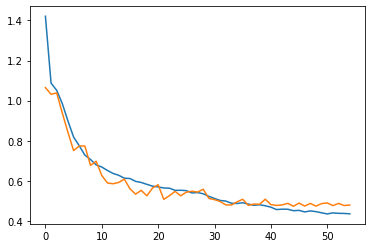

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)

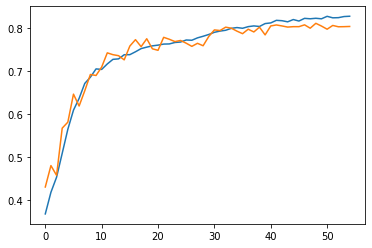

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)